## 4) 1D CNN으로 스팸 메일 분류하기

이미 텍스트 분류 챕터에서 RNN으로 스팸 메일 분류하기를 수행한 적이 있다. 이번 챕터에서는 1D CNN을 이용하여 스팸 메일을 분류해보겠다. 데이터에 대한 자세한 설명은 생략한다.



### 1.데이터에 대한 전처리

우선 스팸 메일 데이터를 받아오고, 전처리를 위한 도구들을 임포트한다.


In [9]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

스팸 메일 데이터를 다운로드한다.


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')

총 샘플의 수를 확인해보자.


In [3]:
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5572


총 5,572개의 샘플이 존재한다. 상위 5개의 샘플만 출력해보자.


In [4]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


불필요한 열을 제거하고 레이블을 0과 1이라는 정수로 바꿔준다.


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


혹시 데이터에 중복이 있지는 않은지 확인해보겠다.


In [6]:
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미이다. v1열은 0 또는 1의 값만을 가지므로 2가 출력되었다. 중복 샘플을 제거해보겠다.


In [7]:
data.drop_duplicates(subset = ['v2'], inplace = True) # v2 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5169


전체 샘플의 수가 5,169개로 줄었다.


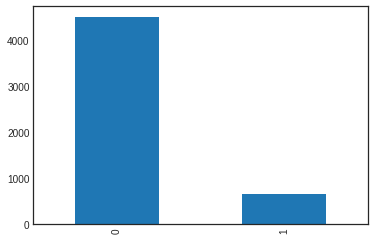

In [10]:
data['v1'].value_counts().plot(kind = 'bar');

레이블이 대부분 0에 편중되어 있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미한다. 수치로 확인해보겠다. 

In [11]:
print(data.groupby('v1').size().reset_index(name = 'count'))

   v1  count
0   0   4516
1   1    653


레이블 0은 총 4,516개가 존재하고 1은 653개가 존재한다. 이제 X와 y를 분리한다. v2열을 X, v1열을 y로 저장한다.


In [12]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수 : {}'.format(len(X_data)))
print('레이블의 개수 : {}'.format(len(y_data)))

메일 본문의 개수 : 5169
레이블의 개수 : 5169


전체 단어의 개수를 1,000개로 제한하고 정수 인코딩을 진행한다.


In [13]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장


상위 5개의 샘플을 출력해보자.


In [14]:
print(sequences[:5])

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137], [49, 306, 435, 6], [53, 537, 8, 20, 4, 934, 2, 220, 706, 267, 70, 2, 2, 359, 537, 604, 82, 436, 185, 707, 437], [6, 226, 152, 23, 347, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 198, 105, 438]]


이제 훈련 데이터와 테스트 데이터의 분리 비율을 정해보겠다. 여기서는 8:2로 정하겠다.


In [16]:
n_of_train = int(len(sequences) * 0.8)
n_of_test  = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :', n_of_train)
print('테스트 데이터의 개수 :', n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수 : 1034


전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 알아보도록 하겠다.


메일의 최대 길이 : 172
메일의 평균 길이 : 12.566841


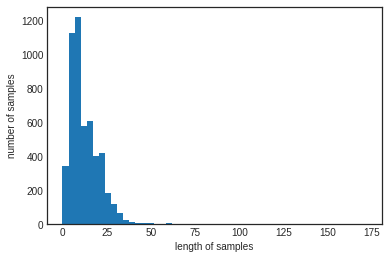

In [17]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data)) / len(X_data)))

plt.hist([len(s) for s in X_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 메일의 길이는 172이며, 전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이를 가지는 것을 볼 수 있다. 


In [18]:
# 전체 데이터셋의 길이는 max_len으로 맞춘다.
max_len = 172
data = pad_sequences(X_data, maxlen = max_len)
print('훈련 데이터의 크기(shape) :', data.shape)

훈련 데이터의 크기(shape) : (5169, 172)


maxlen에는 가장 긴 메일의 길이였던 172이라는 숫자를 넣었다. 이는 5,169개의 X_data의 길이를 전부 172로 바꾼다. 172보다 길이가 짧은 메일 샘플들은 전부 숫자 0이 패딩되어 172의 길이를 가지게 된다.

이제 X_data 데이터는 5,169 x 172의 크기를 갖게 된다. 이제 X_train과 X_test를 분리한다.


In [19]:
X_test = data[n_of_train:] # X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) # y_data 데이터 중에서 뒤의 1034개의 데이터만 저장

X_train = data[:n_of_train] # X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) # y_data 데이터 중에서 앞의 4135개의 데이터만 저장

print('훈련용 이메일 데이터의 크기(shape) :', X_train.shape)
print('테스트용 이메일 데이터의 크기(shape) :', X_test.shape)
print('훈련용 레이블의 크기(shape) :', y_train.shape)
print('테스트용 레이블의 크기(shape) :', y_test.shape)

훈련용 이메일 데이터의 크기(shape) : (4135, 172)
테스트용 이메일 데이터의 크기(shape) : (1034, 172)
훈련용 레이블의 크기(shape) : (4135,)
테스트용 레이블의 크기(shape) : (1034,)


### 2.1D CNN으로 스팸 메일 분류하기


In [20]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides = 1, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [22]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1,
                   patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max',
                     verbose = 1, save_best_only = True)

In [23]:
hist = model.fit(X_train, y_train, epochs = 10,
                 batch_size = 64, validation_split = 0.2,
                 callbacks = [es, mc])

Epoch 1/10
52/52 [==============================] - 3s 32ms/step - loss: 0.5183 - acc: 0.8711 - val_loss: 0.3839 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 1s 22ms/step - loss: 0.3636 - acc: 0.8735 - val_loss: 0.2935 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 1s 21ms/step - loss: 0.2068 - acc: 0.9068 - val_loss: 0.0743 - val_acc: 0.9794

Epoch 00003: val_acc improved from 0.87304 to 0.97944, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 1s 21ms/step - loss: 0.0627 - acc: 0.9833 - val_loss: 0.0513 - val_acc: 0.9843

Epoch 00004: val_acc improved from 0.97944 to 0.98428, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 1s 22ms/step - loss: 0.0312 - acc: 0.9895 - val_loss: 0.0520 - val_acc: 0.9831

Epoch 00005: val_acc did not improve f

In [24]:
print('\n 테스트 정확도 : %.4f' % (model.evaluate(X_test, y_test)[1]))


33/33 [==============================] - 0s 3ms/step - loss: 0.0715 - acc: 0.9826

 테스트 정확도 : 0.9826
